In [1]:
import os
import sys
import gc

In [2]:
XMem_path = os.path.abspath('./XMem')
sys.path.append(XMem_path)
# !wget -P ./saves/ https://github.com/hkchengrex/XMem/releases/download/v1.0/XMem.pth

In [18]:
from collections import Counter
from inspect import getsource
from pathlib import Path
from os import path
import re

import cv2
import numpy as np
from PIL import Image
from skimage import io
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
# from torchmetrics.classification import BinaryJaccardIndex
# from torchmetrics.classification import Dice
from torchmetrics.functional.classification import binary_jaccard_index, multiclass_jaccard_index
from torchmetrics.functional import dice

# from inference.data.test_datasets import LongTestDataset, DAVISTestDataset, YouTubeVOSTestDataset
# from inference.data.mask_mapper import MaskMapper
from model.network import XMem

from inference.inference_core import InferenceCore
from inference.data.mask_mapper import MaskMapper

from inference.interact.interactive_utils import image_to_torch, index_numpy_to_one_hot_torch, torch_prob_to_numpy_mask

from progressbar import progressbar

torch.set_grad_enabled(False)

# default configuration
config = {
    'top_k': 30,
    'mem_every': 5,
    'deep_update_every': -1,
    'enable_long_term': True,
    'enable_long_term_count_usage': True,
    'num_prototypes': 128,
    'min_mid_term_frames': 5,
    'max_mid_term_frames': 10,
    'max_long_term_elements': 10000,
}

if torch.cuda.is_available():
  print('Using GPU')
  device = 'cuda'
else:
  print('CUDA not available. Please connect to a GPU instance if possible.')
  device = 'cpu'

# network = XMem(config, '../XMem/saves/XMem.pth').eval().to(device)

Using GPU


In [4]:
!nvidia-smi

Tue Jan 23 22:32:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0 Off |                  Off |
| 30%   40C    P2              43W / 450W |    723MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# torch.cuda.empty_cache()

# COLOR = (3, 192, 60)


# # Pulmonary Vein
# main_folder = Path("./data")
# VIDEOS_PATH = main_folder/"tframes"
# MASKS_PATH = main_folder/"tmasks"

In [6]:
torch.cuda.empty_cache()

COLOR = (3, 192, 60)

# processor = InferenceCore(network, config=config)
# NUM_OBJECTS = 1 # Binary Segmentation
# processor.set_all_labels(range(1, NUM_OBJECTS+1))

DATASET_TYPE = "endo"
main_folder = Path("./data")
VIDEOS_PATH = main_folder/"frames"
MASKS_PATH = main_folder/"masks"

test_videos = VIDEOS_PATH
test_masks = MASKS_PATH/"all_masks"

In [7]:
# Depreciated
def binary2color(binary_mask, color):
    binary_mask = torch_prob_to_numpy_mask(binary_mask)
    pred_mask = np.tile(binary_mask[..., np.newaxis], (1,1,3)) # Make it 3 Channel
    mask = np.where(pred_mask == (1,)*3, color, 0).astype('uint8') # Convert Prediction with Color
    return mask

In [8]:
def color_map(pred_mask: np.ndarray, gt_mask: np.ndarray):
    # Intersection of pred_mask and gt_mask: True Positive
    true_positive = np.bitwise_and(pred_mask, gt_mask)
    # Only Pred not GT: False Positive
    false_positive = np.bitwise_and(pred_mask, np.bitwise_not(gt_mask))
    # Only GT not Pred: False Negative
    false_negative = np.bitwise_and(np.bitwise_not(pred_mask), gt_mask)

    # Colors
    green = (0, 255, 0)
    red = (255, 0, 0)
    blue = (0, 0, 255)

    # Creating Color Map Image
    h,w = pred_mask.shape[:2]
    color_map = np.zeros((h,w,3), dtype=np.uint8)
    color_map[true_positive!=0] = green
    color_map[false_positive!=0] = red
    color_map[false_negative!=0] = blue

    return color_map

Predicted Mask


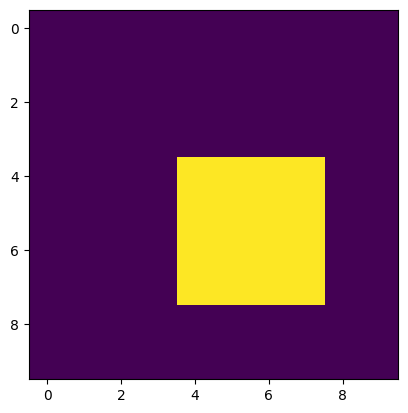

Ground Truth Mask


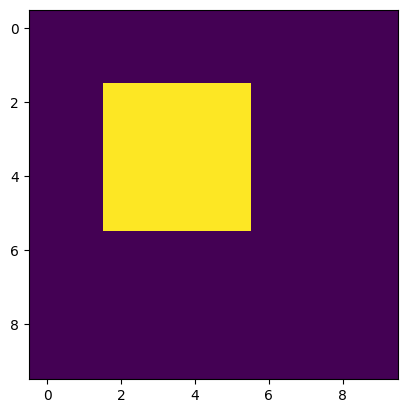

Color Map


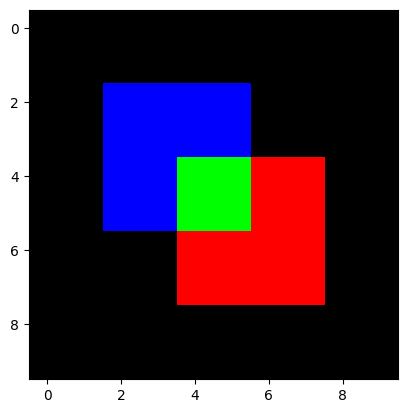

In [9]:
a = np.zeros((10,10), dtype=np.uint8)
a[4:8, 4:8] = 1
b = np.zeros((10,10), dtype=np.uint8)
b[2:6, 2:6] = 1
c = color_map(a, b)
print("Predicted Mask")
plt.imshow(a); plt.show()
print("Ground Truth Mask")
plt.imshow(b); plt.show()
print("Color Map")
plt.imshow(c); plt.show()

In [10]:
def frames2video(frames_dict, folder_save_path, video_name, FPS=5):
    video_path = f'{folder_save_path}/{video_name}_{FPS}FPS.mp4'
    print("Creating video and saving:", video_path)
    frame = frames_dict[list(frames_dict.keys())[-1]]
    size1,size2,_ = frame.shape
    out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), FPS, (size2, size1), True)
    # Sorting the frames according to frame number eg: frame_007.png
    for _,i in sorted(frames_dict.items(), key=lambda x: x[0]):
        out_img = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
        out.write(out_img)
    out.release()

In [11]:
# Depreciated: Implemented inside getIoU function
def pred2overlay(og_frames, pred_frames):
    overlay_dict = {}
    for frame_name, frame in og_frames.items():
        colored_mask = binary2color(pred_frames[frame_name], (34,139,34)) # forestgreen https://www.rapidtables.com/web/color/green-color.html
        overlay = cv2.addWeighted(frame, 1, colored_mask, 0.5, 0)
        overlay_dict[frame_name] = overlay
    return overlay_dict

In [34]:
def getIoU(pred_frames, path_dicts, video=True, og_frames = None, save_path=None, num_obj=1):
    
    IoU = torch.zeros(len(pred_frames), num_obj)
    dice_ = torch.zeros(len(pred_frames), num_obj)
    overlaid_images = {}
    # get the first mask frame from pred_frames dictionary and get its shape
    _,h,w = pred_frames[list(pred_frames.keys())[0]].shape # [0]:first key
    classes_present = Counter()
    classes_predicted = Counter()
    for i, (frame_name, mask) in enumerate(tqdm(pred_frames.items())):
        np_mask = torch_prob_to_numpy_mask(mask) # predictions probabilities to numpy mask
        classes_predicted.update(Counter(np.unique(np_mask)))
            
        torch_mask = torch.tensor(np_mask).to(device)
        
        truth_mask = io.imread(path_dicts[frame_name][1]) # 0: frame_path, 1: mask_path
        truth_mask[truth_mask == 255] = 1
        if np.sum(truth_mask) < (0.01*h*w): # if mask is empty or covers less than 1% of image
            continue
        classes_present.update(Counter(np.unique(truth_mask)))
        
        if video:
            overlaid_images[frame_name] = cv2.addWeighted(og_frames[frame_name], 1, color_map(np_mask, truth_mask), 0.5, 0)
        if save_path:
            io.imsave(save_path/frame_name, np_mask, check_contrast=False)

        truth_mask = torch.tensor(truth_mask).to(device)

        if num_obj > 1:
            # Have to give background too as num_classes, and in output ignoring background by doing [1:]
            IoU[i] = multiclass_jaccard_index(torch_mask, truth_mask, num_classes=num_obj+1, average=None, ignore_index=0)[1:]
            dice_score = dice(torch_mask, truth_mask, num_classes=num_obj+1, average=None, ignore_index=0)[1:]
            dice_[i] = dice_score.masked_fill(dice_score.isnan(), 0)
        else:
            IoU[i] = binary_jaccard_index(torch_mask, truth_mask)
            dice_[i] = dice(torch_mask, truth_mask)


    print("All Present Classes:", classes_present)
    print("All Predicted Classes:", classes_predicted)

    meanIoU = IoU.mean(dim=0) # Mean across num of frames
    meanDice = dice_.mean(dim=0)
    
    return meanIoU, IoU, meanDice, dice, overlaid_images

In [13]:
im_normalization = transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )

def resize_mask(mask, size, num_obj):
        mask = mask.unsqueeze(0).unsqueeze(0)
        h, w = mask.shape[-2:]
        min_hw = min(h, w)
        mask = F.interpolate(mask, (int(h/min_hw*size), int(w/min_hw*size)), 
                    mode='nearest')
        mask = mask.squeeze(0,1).long()
        return F.one_hot(mask, num_classes=num_obj+1).permute(2,0,1).float()

def singleVideoInference(images_paths, first_mask, processor, size = -1, num_obj = 1):
    predictions = {}
    frames = {}
    with torch.cuda.amp.autocast(enabled=True):

        # images_paths = sorted(images_paths)

        # First Frame
        frame = io.imread(images_paths[0])
        og_shape = frame.shape[:2]
        if size < 0:
            im_transform = transforms.Compose([
                transforms.ToTensor(),
                im_normalization,
            ])
        else:
            im_transform = transforms.Compose([
                transforms.ToTensor(),
                im_normalization,
                transforms.Resize(size, interpolation=InterpolationMode.BILINEAR, antialias=False),
            ])
            
        frame_torch = im_transform(frame).to(device)
        first_mask = first_mask.astype(np.uint8)
        if size > 0:
            first_mask = torch.tensor(first_mask).to(device)
            first_mask = resize_mask(first_mask, size, num_obj)
        else:
            first_mask = index_numpy_to_one_hot_torch(first_mask, num_obj+1).to(device)
        
        first_mask = first_mask[1:]    
        prediction = processor.step(frame_torch, first_mask)
        
        for image_path in tqdm(images_paths[1:]):
            frame = io.imread(image_path)
            # convert numpy array to pytorch tensor format
            frame_torch = im_transform(frame).to(device)
            
            prediction = processor.step(frame_torch)
            # Upsample to original size if needed
            if size > 0:
                prediction = F.interpolate(prediction.unsqueeze(1), og_shape, mode='bilinear', align_corners=False)[:,0]
            predictions[image_path.name] = prediction
            frames[image_path.name] = frame

    return frames, predictions

In [14]:
def firstMaskGT(mask_files):

    for idx, mask_path in enumerate(mask_files):        
        
        mask = io.imread(mask_path)
        # All 255 Values replaced with 1, other values remain as it is.
        mask = np.where(mask == 255, 1, mask)
        h,w = mask.shape
        if np.sum(mask) > 0 and ( np.sum(mask) > (0.01*h*w) ): # or can use percentage of image, like > 1%
            return mask, idx
            
    return None, -1

In [39]:
def doInference(network_path, config, sorted_paths, size = -1, video=False):
    overallIoU = []
    overallDice = []
    for pat_name, sorted_paths_dict in sorted_paths.items():
    
        # Clearing GPU Cache
        torch.cuda.empty_cache()
        network = XMem(config, network_path).eval().to(device)
        processor = InferenceCore(network, config=config)
        NUM_OBJECTS = 11
        processor.set_all_labels(range(1, NUM_OBJECTS+1))

        image_files = [img_path for img_path, _ in sorted_paths_dict.values()]
        mask_files = [mask_path for _, mask_path in sorted_paths_dict.values()]
        
        # Getting first Ground Truth mask.
        mask, start_idx = firstMaskGT(mask_files)
        print("Mask starting from:", start_idx)
    
        print(f"Running Inference on {pat_name}...")
        frames, predictions = singleVideoInference(image_files[start_idx:], mask,
                                                  processor, size = size, num_obj = NUM_OBJECTS)
        save_path = None
        if video:
            save_path = Path(f"./pred_masks/{pat_name}")
            os.makedirs(save_path, exist_ok=True)
            
        IoU, _, dice, _, overlaid_images = getIoU(predictions, sorted_paths_dict,
                                 video=video, og_frames = frames, save_path=save_path,
                                 num_obj = NUM_OBJECTS)
        
        print(f"Video \"{pat_name}\", mean IoU is: {IoU*100}")
        print(f"Video \"{pat_name}\", mean dice is: {dice*100}")

        # Convert to Video
        if video:
            os.makedirs("./videos", exist_ok=True)
            frames2video(frames_dict=overlaid_images, folder_save_path = "./videos", video_name=pat_name, FPS=5)
        
        overallIoU.append(IoU)
        overallDice.append(dice)
        print()

        del network, processor
        torch.cuda.empty_cache()
        gc.collect()
    
    print(f"Average IoU over all videos is: {sum(overallIoU)/len(overallIoU)}.")
    print(f"Average Dice over all videos is: {sum(overallDice)/len(overallDice)}.")

    return overallIoU, overallDice

In [16]:
def generate_paths(video_folder_path, mask_folder_path, test_patients=None):
    paths = {}
    for folder in sorted(mask_folder_path.iterdir()):
        pat_name = folder.name if DATASET_TYPE=="endo" else folder.name.split('_')[0]
        if test_patients and pat_name not in test_patients:
            continue
        paths[pat_name] = {}
        for mask_path in folder.iterdir():
            paths[pat_name][mask_path.name] = (video_folder_path/folder.name/mask_path.name, mask_path)
    
    sorted_paths = {pat: {k:v for k,v in sorted(l.items(), key=lambda x: x[0])} for pat, l in paths.items()}

    return sorted_paths

## Check all .pth files and select best

In [17]:
saved_folder = "Jan23_19.31.24_Endo18All_NoAug" # Weights Folder
patient1 = "p14" # Test Patient 1
patient2 = "p20" # Test Patient 2
comb = patient1+patient2

TEST_PATIENTS = None # set([patient1, patient2])
TEST_PATIENTS = set(["seq_17", "seq_18", "seq_19", "seq_20", ])
# TEST_PATIENTS = set(["rll-p01", "p01", "p02", "p03"]) # For RLL PV and LUL PA dataset testing

### Inference using each `.pth` file

In [18]:
paths = []
for network_path in Path(f"./saves/{saved_folder}").iterdir():
    if 'checkpoint' in network_path.name or '.pth' not in network_path.name:
        continue
    paths.append(network_path)

sorted_paths = generate_paths(test_videos, test_masks, test_patients = TEST_PATIENTS)
IoUs = {}
for network_path in sorted(paths, key = lambda x: int(x.name.split('_')[-1].split('.')[0])):
    print(network_path.name)
    overallIoU, overallDice = doInference(network_path, config, sorted_paths, size = 384)
    IoUs[network_path.name] = sum(overallIoU)/len(overallIoU)
    print('*'*100)

Jan23_16.19.01_Endo18Part_RandAffine_250.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 144.75it/s]


Video "seq_17", mean IoU is: tensor([0.7351, 0.5349, 0.5494])
Video "seq_17", mean dice is: tensor([0.7633, 0.5832, 0.6531])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 150.09it/s]


Video "seq_18", mean IoU is: tensor([0.8658, 0.7233, 0.4705])
Video "seq_18", mean dice is: tensor([0.8848, 0.6670, 0.5662])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 146.05it/s]


Video "seq_19", mean IoU is: tensor([0.8617, 0.5912, 0.7294])
Video "seq_19", mean dice is: tensor([0.8759, 0.6187, 0.7747])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 169.31it/s]


Video "seq_20", mean IoU is: tensor([0.4277, 0.4021, 0.2804])
Video "seq_20", mean dice is: tensor([0.4604, 0.4192, 0.3642])

Average IoU over all videos is: tensor([0.7226, 0.5629, 0.5074]).
Average Dice over all videos is: tensor([0.7461, 0.5720, 0.5895]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_500.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 151.14it/s]


Video "seq_17", mean IoU is: tensor([0.7750, 0.5356, 0.4658])
Video "seq_17", mean dice is: tensor([0.7782, 0.5746, 0.5602])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 149.86it/s]


Video "seq_18", mean IoU is: tensor([0.8835, 0.6564, 0.4770])
Video "seq_18", mean dice is: tensor([0.8815, 0.6395, 0.5591])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 151.40it/s]


Video "seq_19", mean IoU is: tensor([0.8852, 0.6205, 0.7027])
Video "seq_19", mean dice is: tensor([0.8832, 0.6504, 0.7666])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 165.86it/s]


Video "seq_20", mean IoU is: tensor([0.4923, 0.4299, 0.2583])
Video "seq_20", mean dice is: tensor([0.4567, 0.4198, 0.3434])

Average IoU over all videos is: tensor([0.7590, 0.5606, 0.4760]).
Average Dice over all videos is: tensor([0.7499, 0.5711, 0.5573]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_750.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 152.78it/s]


Video "seq_17", mean IoU is: tensor([0.7583, 0.5136, 0.4503])
Video "seq_17", mean dice is: tensor([0.7307, 0.5481, 0.5391])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 150.22it/s]


Video "seq_18", mean IoU is: tensor([0.8816, 0.5889, 0.4438])
Video "seq_18", mean dice is: tensor([0.8309, 0.5555, 0.5317])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 152.03it/s]


Video "seq_19", mean IoU is: tensor([0.8777, 0.5953, 0.6604])
Video "seq_19", mean dice is: tensor([0.8298, 0.5939, 0.7232])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 166.11it/s]


Video "seq_20", mean IoU is: tensor([0.4294, 0.3747, 0.2312])
Video "seq_20", mean dice is: tensor([0.3525, 0.3607, 0.3154])

Average IoU over all videos is: tensor([0.7368, 0.5181, 0.4464]).
Average Dice over all videos is: tensor([0.6860, 0.5146, 0.5273]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_1000.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 150.34it/s]


Video "seq_17", mean IoU is: tensor([0.7490, 0.4589, 0.3567])
Video "seq_17", mean dice is: tensor([0.7442, 0.4376, 0.4508])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 153.61it/s]


Video "seq_18", mean IoU is: tensor([0.8659, 0.5184, 0.4107])
Video "seq_18", mean dice is: tensor([0.8713, 0.5013, 0.4878])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 155.70it/s]


Video "seq_19", mean IoU is: tensor([0.8602, 0.5709, 0.6238])
Video "seq_19", mean dice is: tensor([0.8474, 0.5587, 0.6847])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 169.17it/s]


Video "seq_20", mean IoU is: tensor([0.4610, 0.3807, 0.2197])
Video "seq_20", mean dice is: tensor([0.3828, 0.3581, 0.3023])

Average IoU over all videos is: tensor([0.7340, 0.4822, 0.4027]).
Average Dice over all videos is: tensor([0.7114, 0.4639, 0.4814]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_1250.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 150.24it/s]


Video "seq_17", mean IoU is: tensor([0.6507, 0.2880, 0.4536])
Video "seq_17", mean dice is: tensor([0.7074, 0.3782, 0.5370])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 150.80it/s]


Video "seq_18", mean IoU is: tensor([0.7891, 0.3213, 0.3958])
Video "seq_18", mean dice is: tensor([0.8410, 0.4071, 0.5006])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 153.01it/s]


Video "seq_19", mean IoU is: tensor([0.7860, 0.3318, 0.5445])
Video "seq_19", mean dice is: tensor([0.8246, 0.4307, 0.6546])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 172.71it/s]


Video "seq_20", mean IoU is: tensor([0.2266, 0.2507, 0.1581])
Video "seq_20", mean dice is: tensor([0.2435, 0.3001, 0.2324])

Average IoU over all videos is: tensor([0.6131, 0.2980, 0.3880]).
Average Dice over all videos is: tensor([0.6541, 0.3791, 0.4812]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_1500.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 150.98it/s]


Video "seq_17", mean IoU is: tensor([0.6408, 0.4270, 0.5622])
Video "seq_17", mean dice is: tensor([0.6801, 0.4740, 0.6330])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 151.55it/s]


Video "seq_18", mean IoU is: tensor([0.7712, 0.4349, 0.4666])
Video "seq_18", mean dice is: tensor([0.8145, 0.4761, 0.5615])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 152.39it/s]


Video "seq_19", mean IoU is: tensor([0.8285, 0.5034, 0.6434])
Video "seq_19", mean dice is: tensor([0.8245, 0.5611, 0.7049])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 170.44it/s]


Video "seq_20", mean IoU is: tensor([0.3054, 0.2591, 0.2530])
Video "seq_20", mean dice is: tensor([0.3080, 0.2963, 0.3344])

Average IoU over all videos is: tensor([0.6365, 0.4061, 0.4813]).
Average Dice over all videos is: tensor([0.6568, 0.4519, 0.5585]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_1750.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 148.61it/s]


Video "seq_17", mean IoU is: tensor([0.6727, 0.4892, 0.5177])
Video "seq_17", mean dice is: tensor([0.7145, 0.5272, 0.5854])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 153.60it/s]


Video "seq_18", mean IoU is: tensor([0.8264, 0.5189, 0.4543])
Video "seq_18", mean dice is: tensor([0.8609, 0.5306, 0.5415])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 148.27it/s]


Video "seq_19", mean IoU is: tensor([0.8383, 0.5393, 0.6510])
Video "seq_19", mean dice is: tensor([0.8453, 0.5877, 0.7075])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 168.09it/s]


Video "seq_20", mean IoU is: tensor([0.3395, 0.3271, 0.2197])
Video "seq_20", mean dice is: tensor([0.3400, 0.3417, 0.2996])

Average IoU over all videos is: tensor([0.6692, 0.4686, 0.4607]).
Average Dice over all videos is: tensor([0.6902, 0.4968, 0.5335]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_2000.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 149.98it/s]


Video "seq_17", mean IoU is: tensor([0.7046, 0.4827, 0.5500])
Video "seq_17", mean dice is: tensor([0.7239, 0.5252, 0.5885])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 150.89it/s]


Video "seq_18", mean IoU is: tensor([0.8225, 0.4722, 0.4421])
Video "seq_18", mean dice is: tensor([0.8515, 0.5138, 0.5246])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 150.44it/s]


Video "seq_19", mean IoU is: tensor([0.8431, 0.5569, 0.6492])
Video "seq_19", mean dice is: tensor([0.8403, 0.5859, 0.6930])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 168.45it/s]


Video "seq_20", mean IoU is: tensor([0.3526, 0.3302, 0.2575])
Video "seq_20", mean dice is: tensor([0.3478, 0.3642, 0.3350])

Average IoU over all videos is: tensor([0.6807, 0.4605, 0.4747]).
Average Dice over all videos is: tensor([0.6909, 0.4973, 0.5353]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_2250.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 151.82it/s]


Video "seq_17", mean IoU is: tensor([0.7007, 0.5377, 0.5922])
Video "seq_17", mean dice is: tensor([0.7261, 0.5326, 0.5967])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 147.50it/s]


Video "seq_18", mean IoU is: tensor([0.8450, 0.5023, 0.4622])
Video "seq_18", mean dice is: tensor([0.8602, 0.5154, 0.5463])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 153.71it/s]


Video "seq_19", mean IoU is: tensor([0.8398, 0.5547, 0.6788])
Video "seq_19", mean dice is: tensor([0.8467, 0.5618, 0.7061])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 170.21it/s]


Video "seq_20", mean IoU is: tensor([0.3729, 0.3065, 0.2722])
Video "seq_20", mean dice is: tensor([0.3754, 0.3472, 0.3564])

Average IoU over all videos is: tensor([0.6896, 0.4753, 0.5013]).
Average Dice over all videos is: tensor([0.7021, 0.4892, 0.5514]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_2500.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 148.38it/s]


Video "seq_17", mean IoU is: tensor([0.7140, 0.4962, 0.6378])
Video "seq_17", mean dice is: tensor([0.7410, 0.5345, 0.6570])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 150.07it/s]


Video "seq_18", mean IoU is: tensor([0.8637, 0.5278, 0.4707])
Video "seq_18", mean dice is: tensor([0.8725, 0.5481, 0.5473])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 150.42it/s]


Video "seq_19", mean IoU is: tensor([0.8710, 0.5734, 0.7000])
Video "seq_19", mean dice is: tensor([0.8520, 0.5934, 0.7228])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 170.44it/s]


Video "seq_20", mean IoU is: tensor([0.3811, 0.3413, 0.2782])
Video "seq_20", mean dice is: tensor([0.3749, 0.3799, 0.3612])

Average IoU over all videos is: tensor([0.7074, 0.4847, 0.5217]).
Average Dice over all videos is: tensor([0.7101, 0.5140, 0.5721]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_2750.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 151.78it/s]


Video "seq_17", mean IoU is: tensor([0.6827, 0.4297, 0.5990])
Video "seq_17", mean dice is: tensor([0.7199, 0.4935, 0.6271])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 150.66it/s]


Video "seq_18", mean IoU is: tensor([0.8315, 0.5044, 0.4523])
Video "seq_18", mean dice is: tensor([0.8646, 0.5424, 0.5334])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 147.20it/s]


Video "seq_19", mean IoU is: tensor([0.8599, 0.5489, 0.6690])
Video "seq_19", mean dice is: tensor([0.8544, 0.5926, 0.7040])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 169.60it/s]


Video "seq_20", mean IoU is: tensor([0.3642, 0.3098, 0.2480])
Video "seq_20", mean dice is: tensor([0.3759, 0.3617, 0.3307])

Average IoU over all videos is: tensor([0.6846, 0.4482, 0.4921]).
Average Dice over all videos is: tensor([0.7037, 0.4976, 0.5488]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_3000.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 148.88it/s]


Video "seq_17", mean IoU is: tensor([0.6853, 0.4232, 0.5881])
Video "seq_17", mean dice is: tensor([0.7198, 0.4847, 0.6270])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 151.41it/s]


Video "seq_18", mean IoU is: tensor([0.8367, 0.4529, 0.4389])
Video "seq_18", mean dice is: tensor([0.8548, 0.4930, 0.5234])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 151.44it/s]


Video "seq_19", mean IoU is: tensor([0.8379, 0.5271, 0.6462])
Video "seq_19", mean dice is: tensor([0.8379, 0.5810, 0.6941])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 167.73it/s]


Video "seq_20", mean IoU is: tensor([0.3487, 0.3013, 0.2049])
Video "seq_20", mean dice is: tensor([0.3538, 0.3430, 0.2859])

Average IoU over all videos is: tensor([0.6772, 0.4261, 0.4695]).
Average Dice over all videos is: tensor([0.6916, 0.4754, 0.5326]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_3250.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 149.15it/s]


Video "seq_17", mean IoU is: tensor([0.6639, 0.4684, 0.5991])
Video "seq_17", mean dice is: tensor([0.7078, 0.5133, 0.6372])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 151.70it/s]


Video "seq_18", mean IoU is: tensor([0.8219, 0.4974, 0.4459])
Video "seq_18", mean dice is: tensor([0.8491, 0.5147, 0.5295])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 156.90it/s]


Video "seq_19", mean IoU is: tensor([0.8247, 0.5615, 0.6715])
Video "seq_19", mean dice is: tensor([0.8343, 0.5963, 0.7122])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 169.00it/s]


Video "seq_20", mean IoU is: tensor([0.3068, 0.3198, 0.2176])
Video "seq_20", mean dice is: tensor([0.3261, 0.3643, 0.3014])

Average IoU over all videos is: tensor([0.6543, 0.4618, 0.4835]).
Average Dice over all videos is: tensor([0.6793, 0.4972, 0.5451]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_3500.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 150.25it/s]


Video "seq_17", mean IoU is: tensor([0.6823, 0.4716, 0.6032])
Video "seq_17", mean dice is: tensor([0.7204, 0.5170, 0.6387])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 150.52it/s]


Video "seq_18", mean IoU is: tensor([0.8471, 0.4997, 0.4486])
Video "seq_18", mean dice is: tensor([0.8617, 0.5185, 0.5323])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 148.27it/s]


Video "seq_19", mean IoU is: tensor([0.8438, 0.5628, 0.6750])
Video "seq_19", mean dice is: tensor([0.8456, 0.6006, 0.7145])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 172.68it/s]


Video "seq_20", mean IoU is: tensor([0.3201, 0.3204, 0.2237])
Video "seq_20", mean dice is: tensor([0.3352, 0.3648, 0.3076])

Average IoU over all videos is: tensor([0.6733, 0.4636, 0.4876]).
Average Dice over all videos is: tensor([0.6907, 0.5002, 0.5483]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_3750.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 148.08it/s]


Video "seq_17", mean IoU is: tensor([0.6725, 0.4466, 0.5560])
Video "seq_17", mean dice is: tensor([0.7144, 0.4972, 0.5968])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 147.25it/s]


Video "seq_18", mean IoU is: tensor([0.8284, 0.4921, 0.4309])
Video "seq_18", mean dice is: tensor([0.8556, 0.5141, 0.5181])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 146.13it/s]


Video "seq_19", mean IoU is: tensor([0.8295, 0.5486, 0.6545])
Video "seq_19", mean dice is: tensor([0.8444, 0.5939, 0.7066])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 169.42it/s]


Video "seq_20", mean IoU is: tensor([0.3131, 0.3100, 0.1985])
Video "seq_20", mean dice is: tensor([0.3330, 0.3556, 0.2793])

Average IoU over all videos is: tensor([0.6609, 0.4493, 0.4600]).
Average Dice over all videos is: tensor([0.6869, 0.4902, 0.5252]).
****************************************************************************************************
Jan23_16.19.01_Endo18Part_RandAffine_4000.pth
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:01<00:00, 150.51it/s]


Video "seq_17", mean IoU is: tensor([0.6761, 0.4371, 0.5737])
Video "seq_17", mean dice is: tensor([0.7097, 0.4909, 0.6024])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:01<00:00, 152.62it/s]


Video "seq_18", mean IoU is: tensor([0.8315, 0.5013, 0.4446])
Video "seq_18", mean dice is: tensor([0.8463, 0.5132, 0.5252])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:01<00:00, 153.75it/s]


Video "seq_19", mean IoU is: tensor([0.8322, 0.5526, 0.6604])
Video "seq_19", mean dice is: tensor([0.8337, 0.5909, 0.7024])

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:00<00:00, 163.38it/s]


Video "seq_20", mean IoU is: tensor([0.3139, 0.3112, 0.2202])
Video "seq_20", mean dice is: tensor([0.3320, 0.3585, 0.3040])

Average IoU over all videos is: tensor([0.6634, 0.4505, 0.4747]).
Average Dice over all videos is: tensor([0.6804, 0.4884, 0.5335]).
****************************************************************************************************


In [19]:
# Print in Decreasing Order the IoU
sorted_path_iou = sorted(IoUs.items(), key=lambda x: x[1].mean(), reverse=True)
sorted_path_iou[:7]

[('Jan23_16.19.01_Endo18Part_RandAffine_500.pth',
  tensor([0.7590, 0.5606, 0.4760])),
 ('Jan23_16.19.01_Endo18Part_RandAffine_250.pth',
  tensor([0.7226, 0.5629, 0.5074])),
 ('Jan23_16.19.01_Endo18Part_RandAffine_2500.pth',
  tensor([0.7074, 0.4847, 0.5217])),
 ('Jan23_16.19.01_Endo18Part_RandAffine_750.pth',
  tensor([0.7368, 0.5181, 0.4464])),
 ('Jan23_16.19.01_Endo18Part_RandAffine_2250.pth',
  tensor([0.6896, 0.4753, 0.5013])),
 ('Jan23_16.19.01_Endo18Part_RandAffine_2750.pth',
  tensor([0.6846, 0.4482, 0.4921])),
 ('Jan23_16.19.01_Endo18Part_RandAffine_3500.pth',
  tensor([0.6733, 0.4636, 0.4876]))]

In [20]:
print("All .pth files Inference Completed")

All .pth files Inference Completed


In [21]:
from shutil import copy2
# Rename and Copy the best model to `saves`
to_save_path = f"./saves/XMem_Endo18Part_RandAffine.pth"
copy2(f"./saves/{saved_folder}/{sorted_path_iou[0][0]}", to_save_path)

'./saves/XMem_Endo18Part_RandAffine.pth'

In [22]:
# # Rename and Copy the Tensorboard Logs to `saves`
# for tensorboard_path in Path(f"./saves/{saved_folder}").iterdir():
#     if "events.out" not in tensorboard_path.name:
#         continue
#     copy2(tensorboard_path, f"./saves/events.out.tfevents.All-{comb}")
#     break

In [23]:
!aws s3 cp ./saves/XMem_Endo18Part_RandAffine.pth s3://endovis/weights/Endo18Part/

upload: saves/XMem_Endo18Part_RandAffine.pth to s3://endovis/weights/Endo18Part/XMem_Endo18Part_RandAffine.pth


In [24]:
network_path = to_save_path
os.makedirs("./pred_masks", exist_ok=True)
overallIoU, overallDice = doInference(network_path, config, sorted_paths, size = 384, video=True)

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:06<00:00, 37.70it/s]


Video "seq_17", mean IoU is: tensor([0.7750, 0.5356, 0.4658])
Video "seq_17", mean dice is: tensor([0.7782, 0.5746, 0.5602])
Creating video and saving: ./videos/seq_17_5FPS.mp4

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_18...


100%|██████████| 248/248 [00:06<00:00, 38.72it/s]


Video "seq_18", mean IoU is: tensor([0.8835, 0.6564, 0.4770])
Video "seq_18", mean dice is: tensor([0.8815, 0.6395, 0.5591])
Creating video and saving: ./videos/seq_18_5FPS.mp4

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_19...


100%|██████████| 248/248 [00:06<00:00, 40.31it/s]


Video "seq_19", mean IoU is: tensor([0.8852, 0.6205, 0.7027])
Video "seq_19", mean dice is: tensor([0.8832, 0.6504, 0.7666])
Creating video and saving: ./videos/seq_19_5FPS.mp4

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 95
Running Inference on seq_20...


100%|██████████| 153/153 [00:03<00:00, 48.67it/s]


Video "seq_20", mean IoU is: tensor([0.4923, 0.4299, 0.2583])
Video "seq_20", mean dice is: tensor([0.4567, 0.4198, 0.3434])
Creating video and saving: ./videos/seq_20_5FPS.mp4

Average IoU over all videos is: tensor([0.7590, 0.5606, 0.4760]).
Average Dice over all videos is: tensor([0.7499, 0.5711, 0.5573]).


In [25]:
print("Best .pth file Inference Completed")

Best .pth file Inference Completed


### Loop thorugh all best `.pth` from each run and do inference

In [ ]:
paths = []
for network_path in Path(f"./saves").iterdir():
    if 'checkpoint' in network_path.name or '.pth' not in network_path.name:
        continue
    paths.append(network_path)
os.makedirs("./pred_masks", exist_ok=True)

IoUs = {}
for network_path in sorted(paths):
    print(network_path.name)
    # Get testing patients from the file name eg:XMem_BinaryRLLPA_All-p1p2 -> p1, p2
    pat_comb = network_path.name.split("-")[-1]
    p1, p2 = [match.group() for match in re.finditer(r'p(\d{1,2})', pat_comb)]
    print("Test Patients:", p1, p2)
    TEST_PATIENTS = set([p1, p2])
    paths = {pat: {} for pat in TEST_PATIENTS}
    for folder in MASKS_PATH.iterdir():
        pat_name = folder.name.split('_')[0]
        if pat_name not in TEST_PATIENTS:
            continue
        for mask_path in folder.iterdir():
            paths[pat_name][mask_path.name] = (VIDEOS_PATH/folder.name/mask_path.name, mask_path)

    sorted_paths = {pat: {k:v for k,v in sorted(l.items(), key=lambda x: x[0])} for pat, l in paths.items()}

    overallIoU, overallDice = doInference(network_path, config, sorted_paths, size = 384, video=True)
    IoUs[network_path.name] = sum(overallIoU)/len(overallIoU)
    print('*'*100)

### ZeroShot Inference

In [40]:
network_path = "./saves/XMem.pth"
network_path = "./saves/Jan23_19.31.24_Endo18All_NoAug/Jan23_19.31.24_Endo18All_NoAug_2000.pth"

TEST_PATIENTS = set(["seq_17"]) #set(["seq_17", "seq_18", "seq_19", "seq_20", ])
sorted_paths = generate_paths(test_videos, test_masks, test_patients = TEST_PATIENTS)
overallIoU, overallDice = doInference(network_path, config, sorted_paths, size = 384, video=False)

Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
Mask starting from: 0
Running Inference on seq_17...


100%|██████████| 249/249 [00:08<00:00, 29.66it/s]


All Present Classes: Counter({0: 249, 2: 249, 3: 246, 1: 243, 4: 226, 6: 102, 8: 95, 7: 69, 11: 57, 10: 16})
All Predicted Classes: Counter({0: 249, 2: 249, 10: 249, 3: 242, 1: 238, 4: 4, 11: 3})
Video "seq_17", mean IoU is: tensor([83.3279, 58.5480, 68.0044,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  3.2336,  0.0000])
Video "seq_17", mean dice is: tensor([85.7085, 69.5899, 76.3170,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.6262,  0.0000])

Average IoU over all videos is: tensor([0.8333, 0.5855, 0.6800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0323, 0.0000]).
Average Dice over all videos is: tensor([0.8571, 0.6959, 0.7632, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0163, 0.0000]).
